In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, Lambda, Concatenate, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Reshape, Conv2DTranspose
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, concatenate
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, RobustScaler, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
import time

In [2]:
# Create directories for outputs
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_dir = f"thermal_anomaly_results_{timestamp}"
os.makedirs(output_dir, exist_ok=True)
model_dir = os.path.join(output_dir, "models")
os.makedirs(model_dir, exist_ok=True)
plot_dir = os.path.join(output_dir, "plots")
os.makedirs(plot_dir, exist_ok=True)

In [3]:
# ====================== DATA LOADING AND PREPROCESSING ======================
df = pd.read_csv("data.csv")
df = df.drop(columns=["file_name"]) 

# Advanced preprocessing pipeline
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

# Split the data
X_train, X_test = train_test_split(df_scaled, test_size=0.2, random_state=42)
input_dim = df_scaled.shape[1]

# Additional preprocessing options (can be enabled as needed)
use_power_transform = False
if use_power_transform:
    power_transformer = PowerTransformer(method='yeo-johnson')
    X_train = power_transformer.fit_transform(X_train)
    X_test = power_transformer.transform(X_test)

use_robust_scaler = False
if use_robust_scaler:
    robust_scaler = RobustScaler()
    X_train = robust_scaler.fit_transform(X_train)
    X_test = robust_scaler.transform(X_test)

In [4]:
# ====================== UTILITY FUNCTIONS ======================
def calculate_reconstruction_error(model, data):
    reconstructions = model.predict(data)
    mse = np.mean(np.square(data - reconstructions), axis=1)
    return mse, reconstructions

def evaluate_anomaly_detector(model, X_train, X_test, model_name, plot_dir):
    # Calculate reconstruction errors
    train_error, train_reconstructions = calculate_reconstruction_error(model, X_train)
    test_error, test_reconstructions = calculate_reconstruction_error(model, X_test)

    # Set threshold based on training data (e.g., 95th percentile)
    threshold = np.percentile(train_error, 95)

    # Simulate anomalies for demonstration
    predicted_anomalies = test_error > threshold
    simulated_true_anomalies = test_error > np.percentile(test_error, 95)

    # Plot reconstruction error distributions
    plt.figure(figsize=(12, 6))
    plt.hist(train_error, bins=50, alpha=0.5, label='Training Data')
    plt.hist(test_error, bins=50, alpha=0.5, label='Test Data')
    plt.axvline(threshold, color='r', linestyle='--', label=f'Threshold ({threshold:.4f})')
    plt.title(f'Reconstruction Error Distribution - {model_name}')
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()
    plt.close()

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(simulated_true_anomalies, test_error)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.legend(loc="lower right")
    plt.show()
    plt.close()

    # Visualize reconstruction examples
    n_examples = min(5, len(X_test))
    plt.figure(figsize=(15, 5))
    for i in range(n_examples):
        plt.subplot(2, n_examples, i+1)
        plt.plot(X_test[i])
        plt.title(f"Original {i+1}")
        plt.grid(True)
        plt.subplot(2, n_examples, i+n_examples+1)
        plt.plot(test_reconstructions[i])
        plt.title(f"Reconstructed {i+1}")
        plt.grid(True)
    plt.tight_layout()
    plt.show()
    plt.close()

    return train_error, test_error, threshold, predicted_anomalies

def train_and_evaluate_model(model, model_name, X_train, X_test, epochs=100, batch_size=32):
    print(f"Training {model_name}...")
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(
        os.path.join(model_dir, f'{model_name}.keras'),
        monitor='val_loss', 
        save_best_only=True
    )
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

    start_time = time.time()
    history = model.fit(
        X_train, X_train,
        epochs=epochs,
        batch_size=batch_size,
        shuffle=True,
        validation_data=(X_test, X_test),
        callbacks=[early_stopping, model_checkpoint, reduce_lr],
        verbose=1
    )
    training_time = time.time() - start_time
    print(f"{model_name} training completed in {training_time:.2f} seconds")

    # Plot training history
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Training History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.close()

    # Evaluate model
    train_error, test_error, threshold, predicted_anomalies = evaluate_anomaly_detector(
        model, X_train, X_test, model_name, plot_dir
    )

    results = {
        'model_name': model_name,
        'training_time': training_time,
        'mean_train_error': np.mean(train_error),
        'mean_test_error': np.mean(test_error),
        'threshold': threshold,
        'anomalies_detected': np.sum(predicted_anomalies)
    }
    return results, train_error, test_error, predicted_anomalies

In [5]:
# ====================== MODEL DEFINITIONS ======================
def build_advanced_autoencoder(input_dim):
    input_layer = Input(shape=(input_dim,))
    x = Dense(128, activation='elu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(input_layer)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='elu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)
    x = BatchNormalization()(x)

    skip_connection = Dense(32, activation='linear')(x)
    x = Dense(32, activation='elu')(x)
    x = BatchNormalization()(x)
    x = Concatenate()([x, skip_connection])

    attention_weights = Dense(16, activation='softmax', name='attention')(x)
    bottleneck = Dense(16, activation='elu', name='bottleneck')(x)
    encoded = Lambda(lambda inputs: inputs[0] * inputs[1])([bottleneck, attention_weights])

    x = Dense(32, activation='elu')(encoded)
    x = BatchNormalization()(x)
    x = Dense(64, activation='elu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='elu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)
    x = BatchNormalization()(x)
    decoded = Dense(input_dim, activation='sigmoid')(x)

    autoencoder = Model(input_layer, decoded)

    def thermal_gradient_loss(y_true, y_pred):
        mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=-1)
        y_true_grad = tf.abs(y_true[:, 1:] - y_true[:, :-1])
        y_pred_grad = tf.abs(y_pred[:, 1:] - y_pred[:, :-1])
        gradient_loss = tf.reduce_mean(tf.square(y_true_grad - y_pred_grad), axis=-1)
        return mse + 0.5 * gradient_loss

    optimizer = Adam(learning_rate=0.001, clipnorm=1.0)
    autoencoder.compile(optimizer=optimizer, loss=thermal_gradient_loss)
    return autoencoder

In [6]:
def build_temporal_autoencoder(input_dim):
    input_layer = Input(shape=(input_dim,))
    seq_length = 10
    feature_dim = input_dim // seq_length

    if input_dim % seq_length == 0:
        reshaped = Reshape((seq_length, feature_dim))(input_layer)
        x = LSTM(64, return_sequences=True)(reshaped)
        x = LSTM(32, return_sequences=False)(x)
        encoded = Dense(16, activation='relu')(x)
        x = RepeatVector(seq_length)(encoded)
        x = LSTM(32, return_sequences=True)(x)
        x = LSTM(64, return_sequences=True)(x)
        x = TimeDistributed(Dense(feature_dim))(x)
        decoded = Reshape((input_dim,))(x)
    else:
        x = Dense(128, activation='relu')(input_layer)
        x = BatchNormalization()(x)
        x = Dense(64, activation='relu')(x)
        x = BatchNormalization()(x)
        encoded = Dense(32, activation='relu')(x)
        x = Dense(64, activation='relu')(encoded)
        x = BatchNormalization()(x)
        x = Dense(128, activation='relu')(x)
        x = BatchNormalization()(x)
        decoded = Dense(input_dim, activation='sigmoid')(x)

    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder


Training Advanced_Thermal_Autoencoder...
Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - loss: 0.1993 - val_loss: 0.0959 - learning_rate: 0.0010
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1260 - val_loss: 0.0589 - learning_rate: 0.0010
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1011 - val_loss: 0.0492 - learning_rate: 0.0010
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0781 - val_loss: 0.0451 - learning_rate: 0.0010
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0700 - val_loss: 0.0449 - learning_rate: 0.0010
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0584 - val_loss: 0.0439 - learning_rate: 0.0010
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0481 - val_loss: 0.0417 - learning_rate: 0.0010
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0456 - val_loss: 0.0408 - learning_rate: 0.0010
Epoch 9/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0432 - val_loss: 0.04

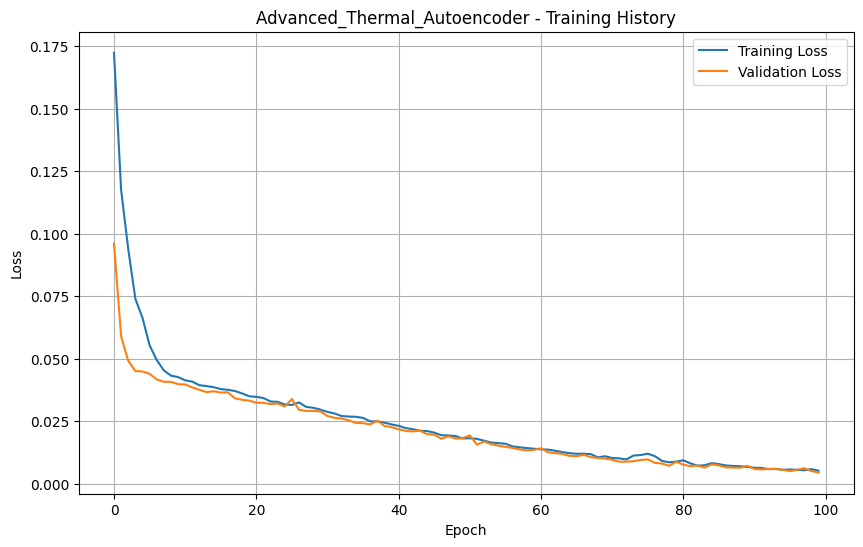

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


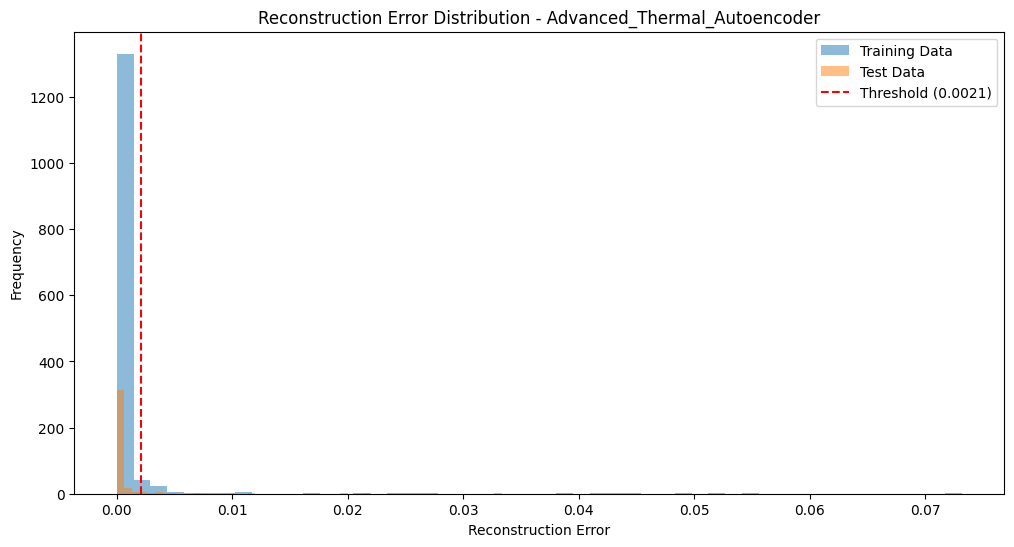

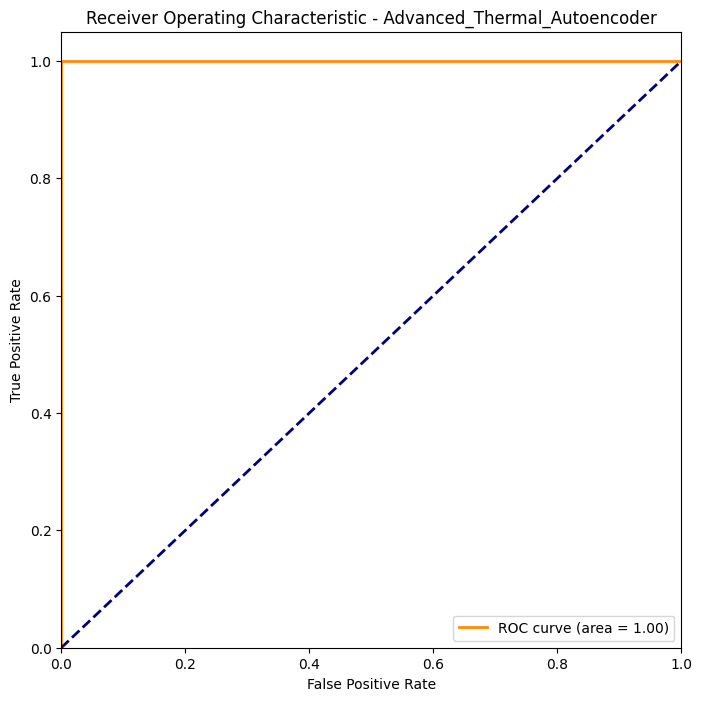

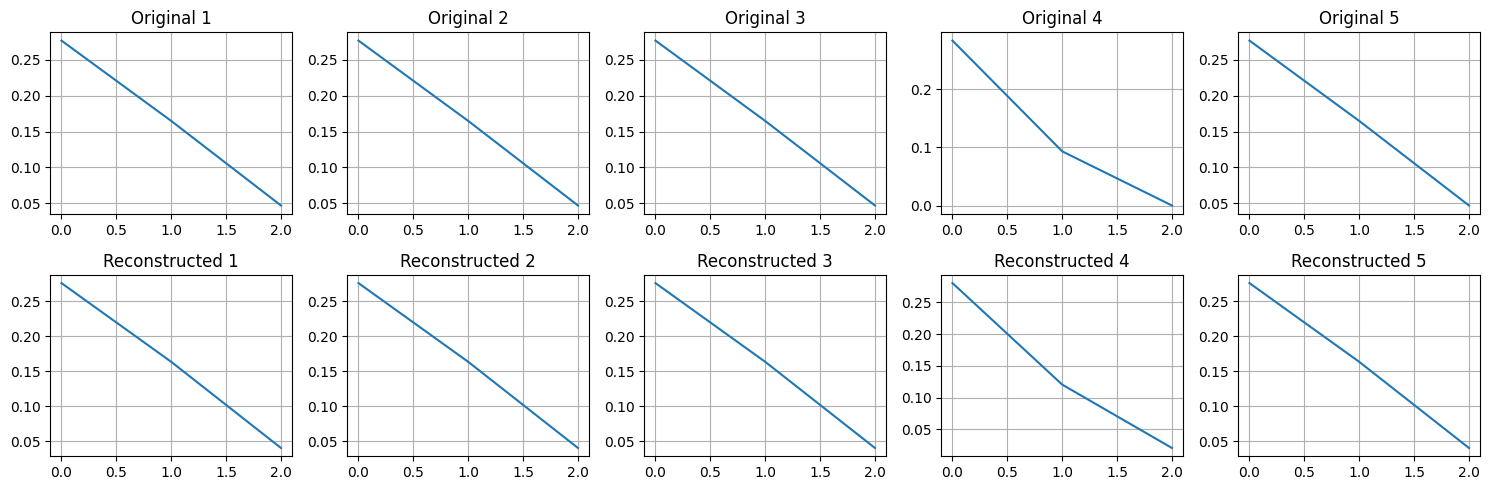

Training Temporal_Autoencoder...
Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.1274 - val_loss: 0.0557 - learning_rate: 0.0010
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0638 - val_loss: 0.0188 - learning_rate: 0.0010
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0434 - val_loss: 0.0084 - learning_rate: 0.0010
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0308 - val_loss: 0.0048 - learning_rate: 0.0010
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0279 - val_loss: 0.0041 - learning_rate: 0.0010
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0218 - val_loss: 0.0039 - learning_rate: 0.0010
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0170 - val_loss: 0.0032 - learning_rate: 0.0010
Epoch 8/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0155 - val_loss: 0.0037 - learning_rate: 0.0010
Epoch 9/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0131 - val_loss: 0.0041 - learnin

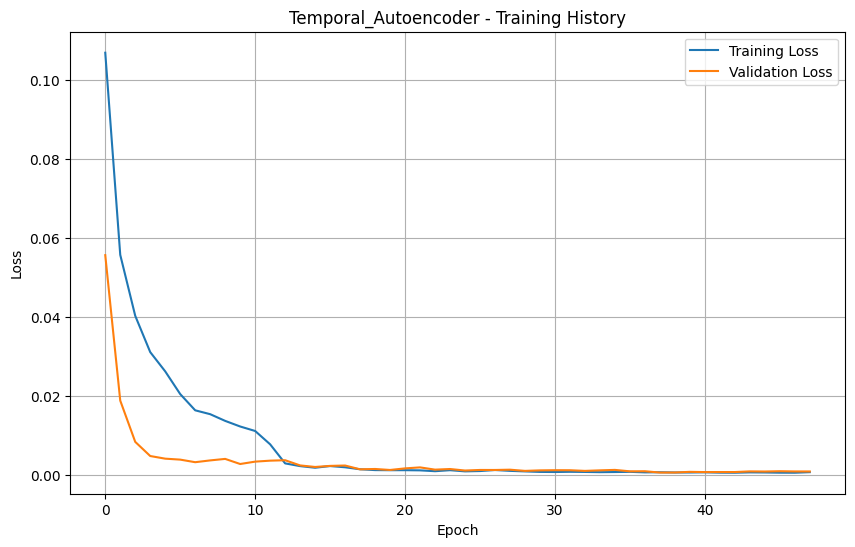

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


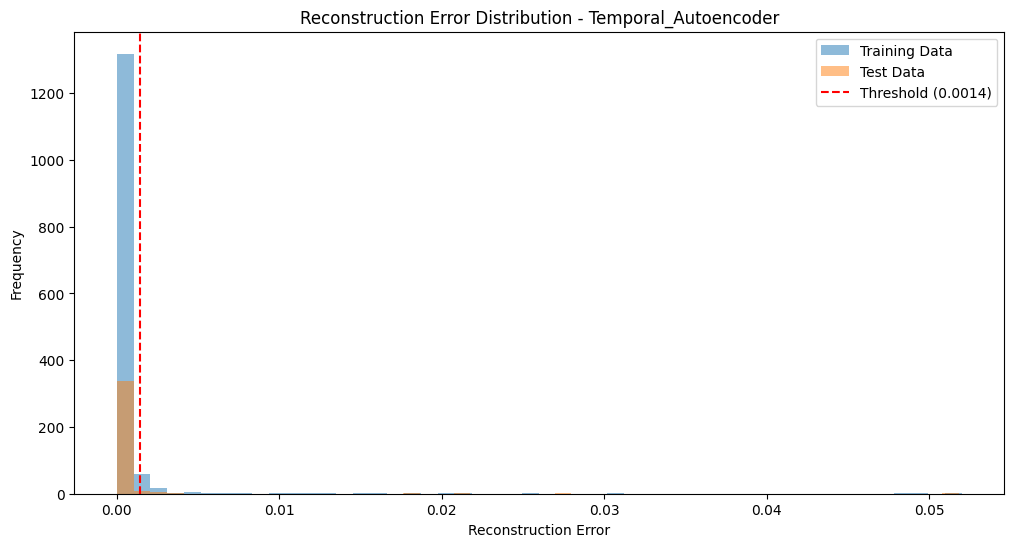

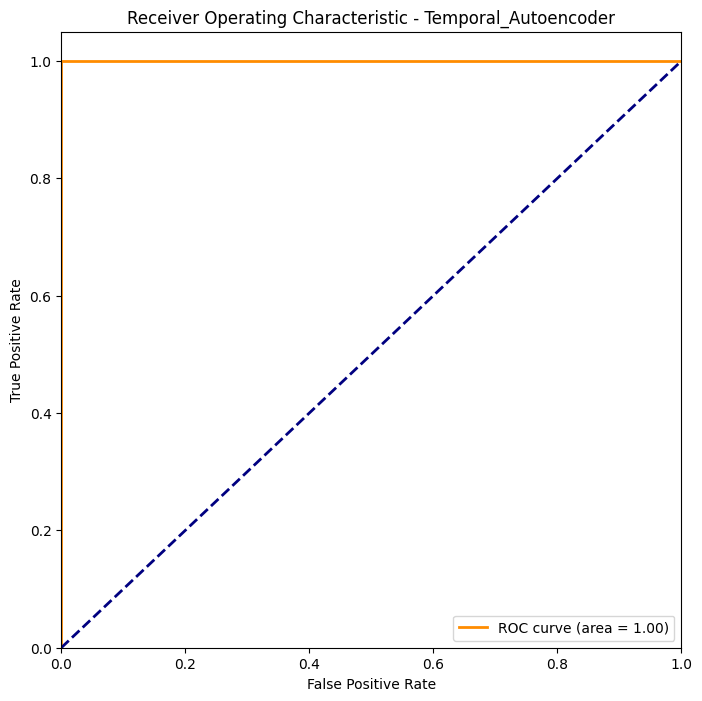

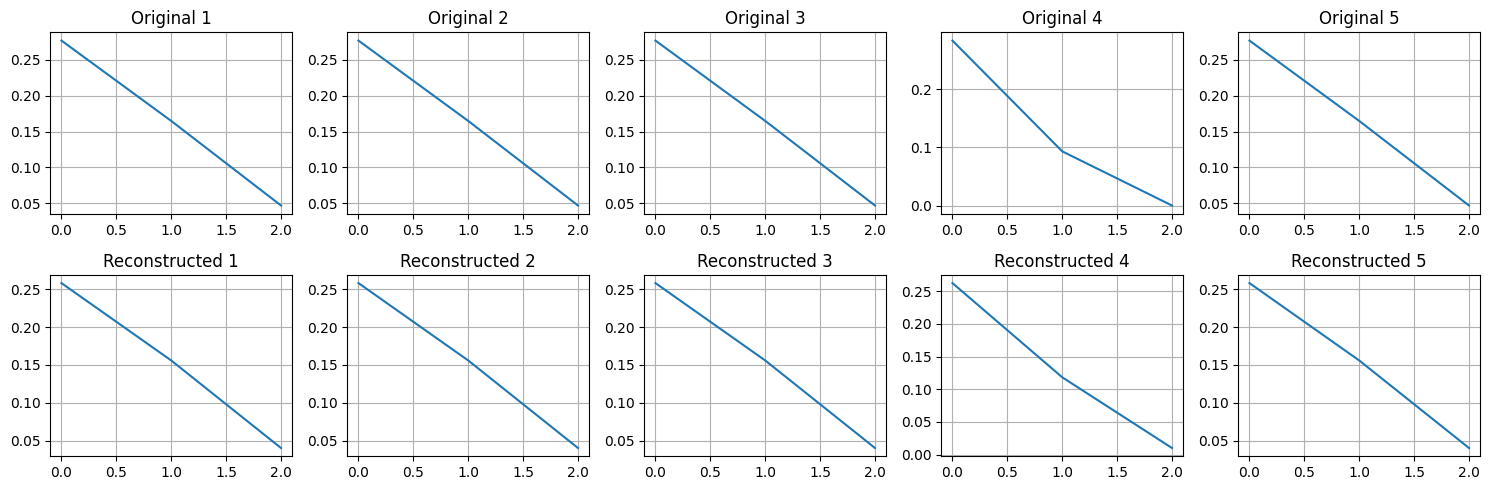

In [7]:
# ====================== MAIN EXECUTION ======================
all_results = []
anomaly_scores = {}

# Train and evaluate Model 1: Advanced Autoencoder
model1 = build_advanced_autoencoder(input_dim)
model1_results, train_error1, test_error1, anomalies1 = train_and_evaluate_model(
    model1, "Advanced_Thermal_Autoencoder", X_train, X_test, epochs=100, batch_size=32
)
all_results.append(model1_results)
anomaly_scores["Advanced_Thermal_Autoencoder"] = test_error1

# Train and evaluate Model 3: Temporal Autoencoder
model3 = build_temporal_autoencoder(input_dim)
model3_results, train_error3, test_error3, anomalies3 = train_and_evaluate_model(
    model3, "Temporal_Autoencoder", X_train, X_test, epochs=100, batch_size=32
)
all_results.append(model3_results)
anomaly_scores["Temporal_Autoencoder"] = test_error3

In [10]:
# ====================== ENSEMBLE METHOD ======================
ensemble_scores = np.zeros_like(test_error1)
for model_name, scores in anomaly_scores.items():
    normalized_scores = (scores - np.min(scores)) / (np.max(scores) - np.min(scores))
    ensemble_scores += normalized_scores
ensemble_scores /= len(anomaly_scores)

ensemble_threshold = np.percentile(ensemble_scores, 95)
ensemble_anomalies = ensemble_scores > ensemble_threshold

plt.figure(figsize=(10, 6))
plt.hist(ensemble_scores, bins=50, alpha=0.7)
plt.axvline(ensemble_threshold, color='r', linestyle='--', label=f'Threshold ({ensemble_threshold:.4f})')
plt.title('Ensemble Anomaly Score Distribution')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.legend()
plt.savefig(os.path.join(plot_dir, 'ensemble_score_distribution.png'))
plt.close()

plt.figure(figsize=(12, 8))
for model_name, scores in anomaly_scores.items():
    normalized_scores = (scores - np.min(scores)) / (np.max(scores) - np.min(scores))
    plt.scatter(range(len(normalized_scores)), normalized_scores, alpha=0.5, label=model_name)
plt.scatter(range(len(ensemble_scores)), ensemble_scores, alpha=0.7, label='Ensemble', color='black')
plt.title('Comparison of Anomaly Scores Across Models')
plt.xlabel('Sample Index')
plt.ylabel('Normalized Anomaly Score')
plt.legend()
plt.savefig(os.path.join(plot_dir, 'model_comparison.png'))
plt.close()

In [9]:
# ====================== RESULTS SUMMARY ======================
results_df = pd.DataFrame(all_results)
results_df.to_csv(os.path.join(output_dir, 'model_performance_summary2.csv'), index=False)

comparison_summary = {
    'Model': list(anomaly_scores.keys()) + ['Ensemble'],
    'Mean Anomaly Score': [np.mean(scores) for scores in anomaly_scores.values()] + [np.mean(ensemble_scores)],
    'Max Anomaly Score': [np.max(scores) for scores in anomaly_scores.values()] + [np.max(ensemble_scores)],
    'Anomalies Detected': [np.sum(scores > np.percentile(scores, 95)) for scores in anomaly_scores.values()] + [np.sum(ensemble_anomalies)]
}
comparison_df = pd.DataFrame(comparison_summary)
comparison_df.to_csv(os.path.join(output_dir, 'model_comparison2.csv'), index=False)
print(comparison_df)

anomaly_results = pd.DataFrame({
    'Advanced_Thermal_Autoencoder': test_error1,
    'Temporal_Autoencoder': test_error3,
    'Ensemble': ensemble_scores
})
anomaly_results.to_csv(os.path.join(output_dir, 'anomaly_scores2.csv'), index=False)
print(f"All results saved to {output_dir}")
print("Analysis complete!")

                          Model  Mean Anomaly Score  Max Anomaly Score  \
0  Advanced_Thermal_Autoencoder            0.000549           0.033328   
1          Temporal_Autoencoder            0.000613           0.051827   
2                      Ensemble            0.014089           0.765950   

   Anomalies Detected  
0                  18  
1                  18  
2                  18  
All results saved to thermal_anomaly_results_20250324_113434
Analysis complete!
